In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

# Ensemble Methods
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse

In [3]:
data = pd.read_csv('data/Sell-Out Data.csv', low_memory=False)

In [4]:
data.head()

,UNIT,DEALER,CHANNEL,SALES CHANNEL,REGION,WEEK,MONTH,QUARTER,YEAR,BRAND,CAPACITY,COMPRESSOR,COMPANY,QUANTITY
0,H-Wall,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Carrier,2.0hp,Variable Speed,CSG,4
1,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Kelvinator,1.0hp,Fixed Speed,CSG,2
2,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Condura,1.0hp,Variable Speed,CSG,2
3,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Condura,1.0hp,Fixed Speed,CSG,2
4,Wrac,ABENSON,Modern Trade,Modern Trade,VISAYAS,Week 1-2018,Jan-18,Q1,2018,Condura,1.0hp,Fixed Speed,CSG,2


In [5]:
data.shape

(347524, 14)

In [6]:
# Convert Quantity to numeric
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Drop empty values
data.dropna(inplace=True)

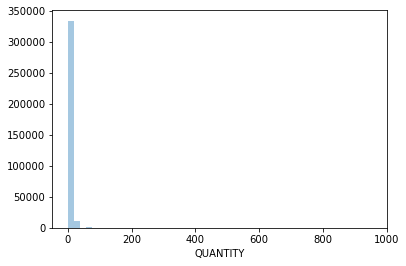

In [7]:
sns.distplot(data.QUANTITY, kde=False)

In [8]:
data.QUANTITY.describe(np.arange(0.1, 1, 0.1))

count    347507.000000
mean          4.520746
std          12.405710
min           0.000000
10%           2.000000
20%           2.000000
30%           2.000000
40%           2.000000
50%           2.000000
60%           2.000000
70%           4.000000
80%           4.000000
90%           6.000000
max         953.000000
Name: QUANTITY, dtype: float64

In [9]:
data_quantity_quantiles = data.QUANTITY.describe(np.arange(0.01, 1, 0.01))
data_quantity_quantiles

count    347507.000000
mean          4.520746
std          12.405710
min           0.000000
1%            1.000000
             ...      
96%          15.000000
97%          38.000000
98%          38.000000
99%          38.000000
max         953.000000
Name: QUANTITY, Length: 104, dtype: float64

### Data Cleaning

In [15]:
# Remove 99th percentile
new_data = data[(data['QUANTITY'] <= data_quantity_quantiles['99%']) &
                (data['QUANTITY'] >= data_quantity_quantiles['1%'])]

# Retain non-competitor data
new_data = new_data[new_data['COMPANY'] != 'Competitors']

# Only use window-type data
new_data = new_data[new_data['UNIT'] != 'Wrac']

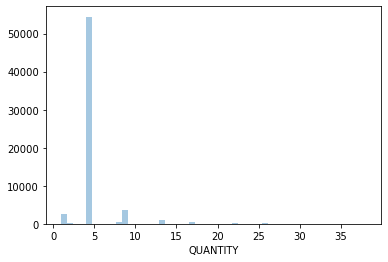

In [16]:
sns.distplot(new_data['QUANTITY'], kde=False)

### Feature Engineering

In [17]:
# Get Features
features = new_data.drop(['QUANTITY', 'YEAR', 'WEEK', 'MONTH', 'QUARTER', 'YEAR', 'UNIT'], axis=1)

# Dummify
X = pd.get_dummies(features)

# Get Targets
y = new_data['QUANTITY']

In [18]:
X.shape, y.shape

((63023, 82), (63023,))

### Modelling

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
# model = GradientBoostingRegressor(n_estimators=300, random_state=42)

# Fit Model
%time model.fit(X_train, y_train)

CPU times: user 9.57 s, sys: 57.8 ms, total: 9.63 s
Wall time: 9.91 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

### Feature Importances

In [28]:
data.REGION.value_counts()

GMA                    114798
NORTH CENTRAL LUZON     85451
SOUTH LUZON             59651
VISAYAS                 46269
MINDANAO                41338
Name: REGION, dtype: int64

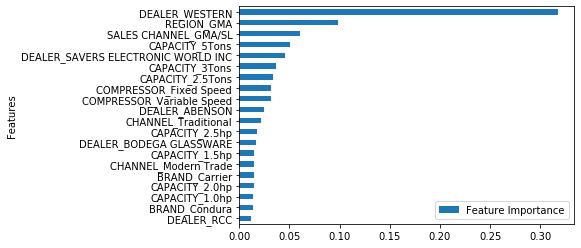

In [20]:
feature_importances_df = pd.DataFrame({"Features": X.columns,
                                       "Feature Importance": model.feature_importances_}
                                     ).sort_values('Feature Importance', ascending=False).set_index('Features')

# Top 20 Features
feature_importances_df[:20].plot(kind='barh')
plt.gca().invert_yaxis()

### RMSE

In [21]:
# Train Predictions
y_pred_train = model.predict(X_train).astype(int)

# Test Predictions
y_pred = model.predict(X_test).astype(int)

# Train RMSE
rmse_score_train = np.sqrt(mse(y_pred_train, y_train))

# Test RMSE
rmse_score = np.sqrt(mse(y_pred, y_test))

In [22]:
rmse_score, rmse_score_train

(2.4759053092469028, 2.2453859635956555)

RMSE is pretty good.

### Compare Predictions from Actual Price

In [23]:
prediction_real_df = pd.DataFrame({"Real Sales Quantity": y_test, "Predicted Sales Quantity": y_pred})

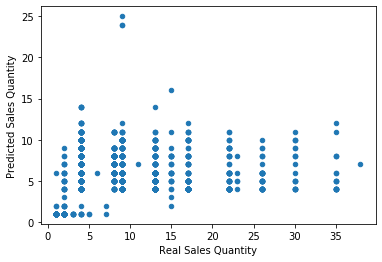

In [24]:
prediction_real_df.plot.scatter('Real Sales Quantity', 'Predicted Sales Quantity')

Predictions are pretty conservative, meaning, they are generally predicting low sale count.

### Another Metric

In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mape

9.60421494657581